Autoencoder Anomaly Testing
===

This is rebuilt from the "Collecting Network Statistics" notebook. The goal of this notebook is to collect together a set of in-distribution and out-of-distribution images and confirm that the model can distinguish them with a high degree of accuracy.


## Setup

We begin by importing our dependencies.

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math

from pytorch_msssim import ssim,ms_ssim,SSIM
from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet,CustomDataSetWithError
import os

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
#seed = 42
seed = 2662
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
#platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 1

#meta-parameters
l2_decay = 0.0
dropout_rate = 0.0
code_sides = [20]
convolution_filters = 32

model_path = "../../Data/OPTIMAM_NEW/model" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) + ".pt"

#image_count = 500
image_count = -1

## Gather Base Distribution Information

First we run the model on the entire original distribution and gather statistics on the loss values, encodings etc.

In [4]:
from torchvision.transforms import ToTensor,Grayscale
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

#root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/"+str(width)
root_dir = "../../Data/OPTIMAM_NEW/png_images/lesions/"
train_dataset = CustomDataSet(root_dir, transform)
if (image_count == -1):
    train_dataset_subset = train_dataset
    image_count = len(train_dataset)
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))
    
train_loader = torch.utils.data.DataLoader(
    train_dataset_subset, shuffle=False
)


In [5]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

code_size = code_sides[0] * code_sides[0]

# mean-squared error loss
criterion = nn.MSELoss()

features = [None] * len(train_dataset_subset)
losses = [None] * len(train_dataset_subset)
encodings = [None] * len(train_dataset_subset)
outputs = [None] * len(train_dataset_subset)

In [6]:
# reload the saved model
model = torch.load(model_path,map_location=device)
model.eval()

SplitAutoencoder(
  (encoder): ExtensibleEncoder(
    (cnnStage): Sequential(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout2d(p=0.0, inplace=True)
      (relu1): ReLU()
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout2): Dropout2d(p=0.0, inplace=True)
      (relu2): ReLU()
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout3): Dropout2d(p=0.0, inplace=True)
      (relu3): ReLU()
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (fc1): Linear(in_features=131072, out_features=400, bias=True)
  )
  (decoder): ExtensibleDecoder(
    (cnnStage): Sequential(


We run our autoencoder on the entire dataset and store the encodings

In [7]:
with torch.no_grad():
    count = 0
    for batch_features in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        features[count] = batch_features.cpu()
        
        # compute reconstructions
        code = model.encoder(batch_features)
        output = model.decoder(code)
        
        outputs[count] = output.cpu()
        
        code_reshaped = code.detach().cpu().numpy()[0]
        code_reshaped.reshape(code_size)

        encodings[count] = code_reshaped

        # compute training reconstruction loss
        error_criterion = criterion(output,batch_features)

        losses[count] = error_criterion.cpu().numpy()

        count = count + 1

C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


And calculate the encoding statistics:

In [8]:
print(len(encodings))
print(len(encodings[0]))
print(len(losses))

8775
400
8775


In [9]:
feature_means = np.mean(encodings,axis=0)
feature_stds = np.std(encodings,axis=0)
print(len(feature_means))
print(len(feature_stds))

mse_min = np.amin(losses)
mse_max = np.amax(losses)
mse_mean = np.mean(losses)
print("MSE Min/Mean/Max:" + str(mse_min) + "/" + str(mse_mean) + "/" + str(mse_max))

400
400
MSE Min/Mean/Max:0.00036153197/0.0022307367/0.011952042


In [12]:
features_n = np.stack(features)
outputs_n = np.stack(outputs)
print(features_n.shape)
print(outputs_n.shape)

pre_ssims = [None] * image_count

ssim_module = SSIM(data_range=1.0, size_average=False, channel=3)

for i in range(image_count):
    features_s = features_n[i].reshape(1,1,height,width).repeat(3,1)
    outputs_s = outputs_n[i].reshape(1,1,height,width).repeat(3,1)
    ssim_f = ssim_module(torch.from_numpy(features_s), torch.from_numpy(outputs_s))
    pre_ssims[i] = ssim_f.item()
    
ssim_min = np.amin(pre_ssims)
ssim_max = np.amax(pre_ssims)
ssim_mean = np.mean(pre_ssims)
print("SSIM Min/Mean/Max:" + str(ssim_min) + "/" + str(ssim_mean) + "/" + str(ssim_max))

(8775, 1, 1, 256, 256)
(8775, 1, 1, 256, 256)
SSIM Min/Mean/Max:0.2673346698284149/0.801207547972345/0.9675547480583191


Now we save the compiled statistics to an excel file.

In [13]:
with torch.no_grad():
    np_losses = np.asarray(losses)
    np_pre_ssims = np.asarray(pre_ssims)
    np_compiled = np.concatenate((np_losses[:, np.newaxis], encodings), axis=1)

    suffix =  "_" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay)
    
    np.savetxt('base_encodings' + suffix + '.csv', encodings, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_losses' + suffix + '.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_ssim' + suffix + '.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_combined' + suffix + '.csv', np_compiled, delimiter=',',fmt='%10.5f',newline='\n')

## Adversarials

We have 2 Datasets (mammographic and non-mammographic) and 3 DataLoaders - Clean Mammo, Distorted Mammo, and Non-Mammo. The goal here is to build an analogously large set of OOD images and test to what degree the autoencoder is capable of detecting the distortions.

The first method for doing this builds a large set of all the datasets classified into In-Distribution and Out-Of-Distribution and determine the accuracy rating of the model as a classifier. The second generates a set of distorted mammographic images at specified distances from the distribution, along with a value roughly analogous to that distortion level. This second method is intended to determine the range in distribution space at which the model becomes able to distinguish, as well as the degree of "grey area" between in and out of distribution (as detected).

In [14]:
with torch.no_grad():
    trigger_chance = 0.8

    PIL_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=15,translate=(0.4,0.4),shear=60),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.GaussianBlur(kernel_size=5),
        torchvision.transforms.ColorJitter(brightness=0.8,contrast=0.8)
        ],p=trigger_chance)

    adversarial_transform = torchvision.transforms.Compose([
        PIL_transforms,
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.0,1.0),
        torchvision.transforms.RandomErasing(p=trigger_chance),
        ])

    adversarial_image_count = image_count
    adversarial_dataset = CustomDataSetWithError(root_dir, adversarial_transform)
    
    #adversarial_subset = torch.utils.data.Subset(adversarial_dataset, np.random.choice(len(adversarial_dataset), adversarial_image_count, replace=False))

    adversarial_loader = torch.utils.data.DataLoader(
        adversarial_dataset, shuffle=True
    )
    

Build the first (mixed) set:

In [15]:
with torch.no_grad():
    adversarial_iterator = iter(adversarial_loader)
    genuine_iterator = iter(train_loader)
    mixed_set_scale = 300
    
    mixed_set = []
    mixed_set_np = []
    mixed_class_set = []
    mixed_error_set = []
    for i in range(mixed_set_scale):
        r = torch.rand(1)
        if(r.item() > 0.5):
            adversarial_t = next(adversarial_iterator)
            adversarial = adversarial_t[0].cpu()
            adversarial_np = adversarial.numpy().reshape(width,height)
            adv_error = adversarial_t[1]
            mixed_class_set.append(0)
            mixed_set_np.append(adversarial_np)
            mixed_set.append(adversarial)
            mixed_error_set.append(adv_error)
        else:
            genuine = next(genuine_iterator).cpu()
            genuine_np = genuine.numpy().reshape(width,height)
            mixed_class_set.append(1)
            mixed_set.append(genuine)
            mixed_set_np.append(genuine_np)
            mixed_error_set.append(0.0) # genuine, so no drift
        
    mixed_code_set = []
    mixed_reconstruction_set = []

Now run the model on the mixed set:

In [16]:
with torch.no_grad():
    for mixed_item in mixed_set:
        mixed_example = mixed_item.to(device)
        
        n_code = model.encoder(mixed_example)
        reconstruction = model(mixed_example)
        
        mixed_code_set.append(n_code.cpu())
        mixed_reconstruction_set.append(reconstruction.cpu())

Next, measure the loss and feature statistics for the adversarials:            

MSE:

In [17]:
mean_squared_errors = []

for image_n in range(mixed_set_scale):
    print(np.shape(mixed_reconstruction_set[image_n]))
    recon = mixed_reconstruction_set[image_n][0][0]
    original = mixed_set[image_n][0][0]
    t_se = 0.0
    q = []
    n = 0
    t_min = 65535.0
    t_max = 0.0
    for y in range(height):
        p = []
        for x in range(width):
            base_pixel = original[y][x].item()
            recon_pixel = recon[y][x].item()
            #specifically ignore all-black pixels
            if(base_pixel < t_min):
                t_min = base_pixel
            if(base_pixel > t_max):
                t_max = base_pixel
            se = (recon_pixel - base_pixel) ** 2
            p.append(se)
            t_se = t_se + se
            n = n + 1
        q.append(p)
    #print(q)
    
    mse = t_se / n
    #print("Class:" + str(mixed_class_set[image_n]))
    #print("n:" + str(n))
    #print("TSE:" + str(t_se))
    #print("MSE:" + str(mse))
    #print("Base Pixel Minimum Value:" + str(t_min))
    #print("Base Pixel Maximum Value:" + str(t_max))
    #print("\n") 
    
    mean_squared_errors.append(mse)

torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1,

Feature divergence:

In [18]:
g = np.ma.masked_equal(feature_stds,0)
print(feature_means)
for i in range(mixed_set_scale):
    adv_divergence = (mixed_code_set[i] - feature_means) / g
    print(np.max(adv_divergence,axis=1))

[ 17.964237   -10.340834     7.277066   -17.112883    -6.2992887
  -1.9624332  -48.667694     7.24117    -46.82909    -21.926878
 -11.003678     1.5128653    3.1184287   37.565464    15.8165655
 -15.876403    -0.2288622   19.15551    -18.490906    11.166985
  18.56561      1.4014871    9.091009     1.6904706  -10.738677
 -12.109562    15.510539    22.898827     4.3432107  -31.026703
 -24.093615    -9.550177   -18.413036    27.384296   -11.510767
 -10.905231    18.790934    18.600178    22.919       -4.23402
  -8.196704   -52.175907    27.656324   -31.357624    12.0742235
   3.585762    29.876085    17.422813    26.646605   -28.237307
  -6.969678    -5.3330326   -6.2191663   -3.3529668   -6.3876977
  -0.30896148  39.752197     5.8431225   -2.1849391   12.547116
 -19.88541     -1.34363    -25.015062    -4.5155168   13.92003
  40.6413      44.40282    -30.796356   -16.751474    26.675045
 -36.497837   -25.472248    11.096035    -4.5353813  -24.775148
   3.2345665  -17.712158     8.906019 

Generate RGB versions of the base and recreated images.

In [19]:
mixed_set_s = np.stack(mixed_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
mixed_recon_s = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
print(mixed_set_s.shape)
print(mixed_recon_s.shape)

(300, 3, 256, 256)
(300, 3, 256, 256)


And use that for Structural Similarity Index:

In [20]:
ssim_t = ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)
print(ssim_t)
ms_ssim_t = ms_ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)
print(ms_ssim_t)


tensor([4.9457e-01, 5.8227e-01, 1.9768e-01, 8.4263e-01, 7.5563e-01, 8.4652e-01,
        8.0235e-01, 6.0375e-01, 7.9871e-01, 7.8048e-01, 7.1385e-01, 7.7089e-01,
        6.9117e-01, 5.9635e-01, 8.2900e-01, 5.5929e-01, 5.4200e-01, 7.9038e-01,
        4.7184e-01, 7.6535e-01, 6.9864e-01, 5.7133e-01, 1.4994e-01, 5.6511e-01,
        1.9122e-02, 8.8185e-01, 8.3663e-01, 5.3864e-01, 1.7795e-01, 8.6248e-01,
        1.4528e-01, 8.6038e-01, 3.4612e-01, 8.1470e-01, 8.8969e-01, 5.6304e-01,
        1.9102e-01, 3.7950e-02, 6.5748e-01, 8.3220e-01, 5.8618e-01, 8.9639e-01,
        2.4615e-01, 1.5696e-01, 8.6787e-01, 6.4618e-01, 8.8487e-01, 8.3131e-01,
        2.7469e-01, 6.6442e-01, 5.2314e-08, 7.9806e-01, 4.2696e-01, 4.8231e-04,
        8.4249e-01, 7.4865e-01, 7.9607e-01, 7.5314e-01, 7.4207e-01, 7.1867e-01,
        8.4966e-01, 8.0892e-01, 7.8656e-01, 7.9192e-01, 3.9300e-01, 7.4695e-01,
        7.5472e-01, 7.3584e-01, 5.5079e-01, 7.5307e-01, 4.7866e-01, 6.9294e-01,
        8.8648e-01, 5.9328e-01, 7.5370e-

In [21]:
with torch.no_grad():
    np_post_losses = np.asarray(mean_squared_errors)
    np_post_ssims = np.asarray(ssim_t)
    np_distances = np.asarray(mixed_error_set)
    
    suffix =  "_" + str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay)
    
    np.savetxt('mixed_losses' + suffix + '.csv', np_post_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_ssim' + suffix + '.csv', np_post_ssims, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_distance' + suffix + '.csv', np_distances, delimiter=',',fmt='%10.5f',newline='\n')

Attempt to predict the class based on the SSIM:

In [31]:
#ssim_threshold = ssim_mean
ssim_threshold = ssim_min
predicted_class = []
for i in range(mixed_set_scale):
    if(ssim_t[i]>ssim_threshold):
        predicted_class.append(1) # distribution
    else:
        predicted_class.append(0) # adversarial

mixed_class_np = np.asarray(mixed_class_set)
predicted_class_np = np.asarray(predicted_class)
print(mixed_class_np)
print(predicted_class_np)
matches = (mixed_class_np == predicted_class_np)
print(matches)
hits = np.count_nonzero(matches)
misses = mixed_set_scale - hits
accuracy = hits / mixed_set_scale
print("Accuracy:" + str(accuracy))

[0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0
 0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0
 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0
 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0
 1 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1
 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0
 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 1 0 0 0 1 1
 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1
 0 0 0 1]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0
 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0
 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 

And plot the first 10 results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 256, 256, 3)
(300, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


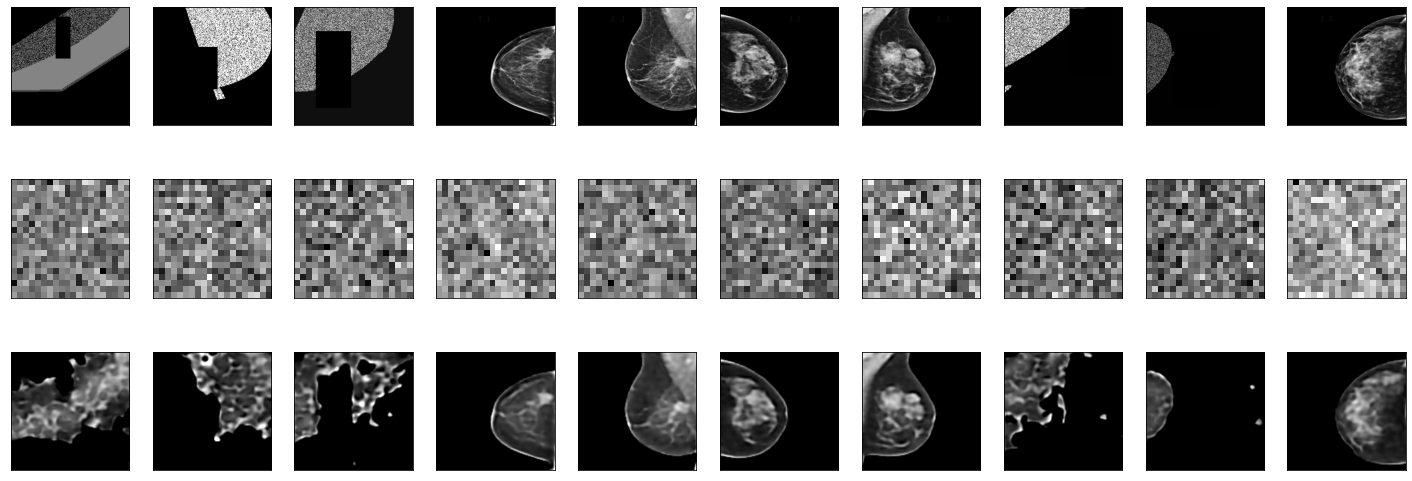

In [23]:
with torch.no_grad():
    mixed_set_g = np.stack(mixed_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    mixed_recon_g = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    print(mixed_set_g.shape)
    print(mixed_recon_g.shape)

    #number = mixed_set_scale
    number = 10
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = mixed_set_g
        copyback = test_examples[index]
        print(copyback.shape)
        plt.imshow(copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + number + 1)
        codes = mixed_code_set
        code_copyback = codes[index].cpu()
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + (number*2) + 1)
        reconstruction = mixed_recon_g
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    out_path = "adv_output"+ str(width) + "_"  + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay) +".png"
    plt.savefig(out_path)
    plt.show()